<a href="https://colab.research.google.com/github/shrushenoy/Predicting-No-Show-Rate-for-Hospital-Appointments/blob/master/Patients%20No-Show%20Prediction%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting No-Show Rate for Hospital Appointments**
In healthcare, no-show for a scheduled appointment is one of the most significant factor that impacts the healthcare delivery services. In 2017, U.S. healthcare industry had loss of $150 billions. The no-show rate is as high as 30% in U.S, there are various factors leading to this number. A model to predict no-show accurately and to take necessary interventions can be implemented to reduce the impact on healthcare.




### Importing necessary packages

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import time
import datetime as dt
sns.set_style("whitegrid")
from scipy.stats import chi2_contingency
import seaborn as sns
from string import ascii_letters

from sklearn import tree
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
ls

gdrive/  sample_data/


### Data Loading

Data Load in Google Colab.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [0]:
#cd into directory of your dataset 

In [0]:
df = pd.read_csv('noshow.csv')
print('Dataset shape:', df.shape[0], '\n\n')
df.head()

Dataset shape: 410526 




,Age,Gender,AppointmentRegistration,ApointmentData,Day,Status,Diabetes,Alcoolism,HiperTension,Handcap,Scholarship,Sms_Reminder
0,19,M,2014-12-16T14:46:25Z,2015-01-14T00:00:00Z,Tuesday,noshow,0,0,0,0,0,0
1,24,F,2015-08-18T07:01:26Z,2015-08-19T00:00:00Z,Tuesday,noshow,0,0,0,0,0,0
2,4,F,2014-02-17T12:53:46Z,2014-02-18T00:00:00Z,Monday,noshow,0,0,0,0,0,0
3,5,M,2014-07-23T17:02:11Z,2014-08-07T00:00:00Z,Wednesday,noshow,0,0,0,0,0,0
4,38,M,2015-10-21T15:20:09Z,2015-10-27T00:00:00Z,Wednesday,noshow,0,0,0,0,0,0


Data Load on local system

In [0]:
#df = pd.read_csv('noshow.csv')
#df.head()

### Data Cleaning & Exploration

In [0]:
#renaming column to make it easier 
new_col_name = ['age', 'gender','schedule_day','appointment_day','week_day', 'no_show',
                'diabetes','alcoholism','hypertension','handicap', 'scholarship',
                'sms_received']
df.columns = new_col_name
df.head()

,age,gender,schedule_day,appointment_day,week_day,no_show,diabetes,alcoholism,hypertension,handicap,scholarship,sms_received
0,19,M,2014-12-16T14:46:25Z,2015-01-14T00:00:00Z,Tuesday,noshow,0,0,0,0,0,0
1,24,F,2015-08-18T07:01:26Z,2015-08-19T00:00:00Z,Tuesday,noshow,0,0,0,0,0,0
2,4,F,2014-02-17T12:53:46Z,2014-02-18T00:00:00Z,Monday,noshow,0,0,0,0,0,0
3,5,M,2014-07-23T17:02:11Z,2014-08-07T00:00:00Z,Wednesday,noshow,0,0,0,0,0,0
4,38,M,2015-10-21T15:20:09Z,2015-10-27T00:00:00Z,Wednesday,noshow,0,0,0,0,0,0


In [0]:
df.dtypes

age                 int64
gender             object
schedule_day       object
appointment_day    object
week_day           object
no_show            object
diabetes            int64
alcoholism          int64
hypertension        int64
handicap            int64
scholarship         int64
sms_received        int64
dtype: object

In [0]:
#checking for null values
df.isnull().sum()

age                0
gender             0
schedule_day       0
appointment_day    0
week_day           0
no_show            0
diabetes           0
alcoholism         0
hypertension       0
handicap           0
scholarship        0
sms_received       0
dtype: int64

In [0]:
#creating a function to find unique values for each feature 
def data(df, limit=5):  
    print(f"Dataset Shape: {df.shape}")
    print('Unique values in feature: ')
    print(df.nunique())
        
data(df)

Dataset Shape: (410526, 12)
Unique values in feature: 
age                   110
gender                  2
schedule_day       398972
appointment_day       561
week_day                6
no_show                 2
diabetes                2
alcoholism              2
hypertension            2
handicap                5
scholarship             2
sms_received            2
dtype: int64


In [0]:
#sns.heatmap(df.isnull())

**Initial Steps and Observations** 

1. There are 11 independent variable and 1 dependent variable (no_show)
2. Renames column names for easier understanding. 
3. The dataset does not have any null values. 
4. The variable schedule_day and appointment_day should changed from object to datetime format. 
5. For appointment_day, there is no time mentioned which makes it difficult to analyze if appointment time has any relation with no-show. 

In [0]:
#basic statistics 
df.describe()

,age,diabetes,alcoholism,hypertension,handicap,scholarship,sms_received
count,410526.000000,410526.000000,410526.000000,410526.000000,410526.000000,410526.000000,410526.000000
mean,37.614465,0.076324,0.026461,0.210871,0.020988,0.097268,0.478727
std,22.892679,0.265516,0.160502,0.407927,0.157466,0.296323,0.499548
min,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,115.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000


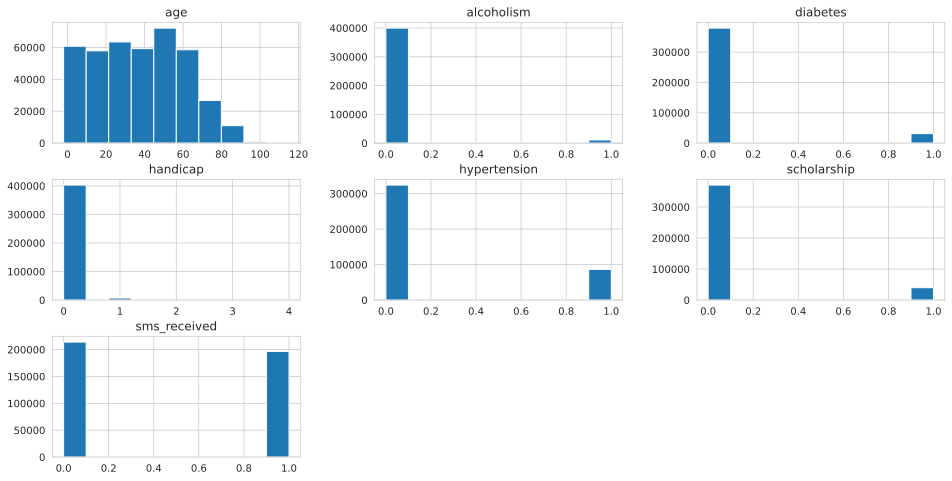

In [0]:
df.hist(figsize=(16,8));

**Observations so far**
1. **age:** Average age is around 37 years. But, age ranges between -2 and 115 years old and corrective action is needed as age cannot below less than 0 and there are very few old people. Need to investigate and take necessary action. 
2. **handicap:** Handicap has 4 values ranging from 0 to 4 and 75 percent of handicap have 0 value.
3. **sms_received:** Around 75% of patients have received sms reminder for their appointment.

Mapping independent 'no_show' variable

In [0]:
df.no_show.unique()

array(['noshow', 'showup'], dtype=object)

In [0]:
df['en_no_show'] = df['no_show'].map({'showup': 1, 'noshow': 0})
df.head(3)

,age,gender,schedule_day,appointment_day,week_day,no_show,diabetes,alcoholism,hypertension,handicap,scholarship,sms_received,en_no_show
0,19,M,2014-12-16T14:46:25Z,2015-01-14T00:00:00Z,Tuesday,noshow,0,0,0,0,0,0,0
1,24,F,2015-08-18T07:01:26Z,2015-08-19T00:00:00Z,Tuesday,noshow,0,0,0,0,0,0,0
2,4,F,2014-02-17T12:53:46Z,2014-02-18T00:00:00Z,Monday,noshow,0,0,0,0,0,0,0


Unique values of no-show:  [0 1] 



[Text(0, 0.5, 'count'), Text(0.5, 0, 'no_show')]

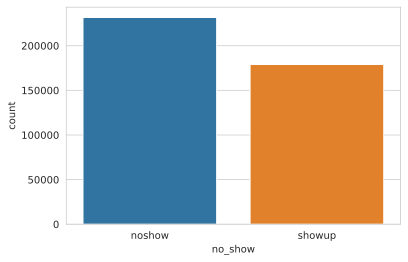

In [0]:
#checking unique value for no_show column
print('Unique values of no-show: ', df.en_no_show.unique(), '\n')
ax = sns.countplot(x='no_show', data =df)
ax.set(xlabel="no_show", ylabel = "count")

Updating Age values

Age range:  [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 108, 113, 115]


 Age Distribution


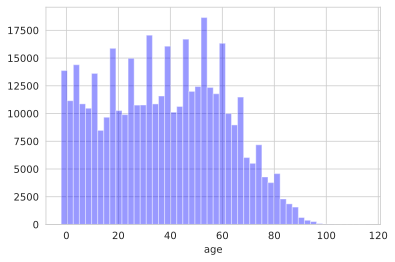

In [0]:
#checking uniques age values
print ("Age range: ", sorted(df['age'].unique()))


#Plotting graph for age 
print('\n\n Age Distribution')
sns.distplot(df['age'], hist=True, kde=False, color = 'blue')
plt.show()

**Obervations:**

Age values are between -2 to 115 years. As seen in the graph there are very few records above the age of 95 years. Updating the age range between 0 to 95 years.

In [0]:
# dropping -ve age and row above 95 years
df = df[(df.age >= 0) & (df.age <= 95)]

min_age = df['age'].min()
max_age = df['age'].max()
print ("Age now spans values from: {} to {}.".format(min_age, max_age))

Age now spans values from: 0 to 95.


**What age ranges patient tend to have highest no show rate?**

Creating age bins to verfiy which age group is more likely to have no-show

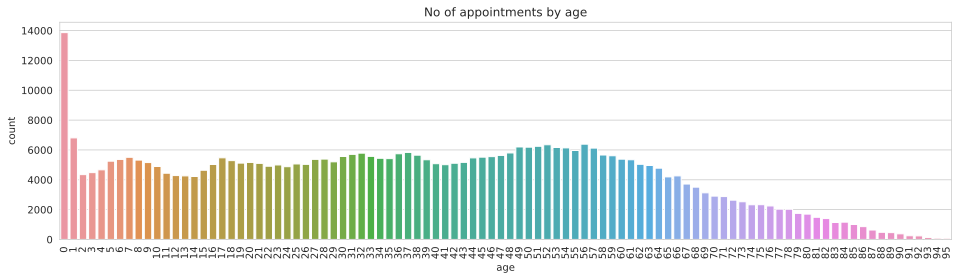

In [0]:
# Let's see how many there are patients of each age
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax = sns.countplot(x=df.age)
ax.set_title("No of appointments by age")
plt.show()

In [0]:
#Creating bins for age groups 
age_ranges = [0, 12, 18, 25, 60, 75]
age_names = ["Children", "Teenager", 'Young-Adult', 'Adult', 'Senior']

df['age_bin'] = pd.cut(np.array(df['age']),bins=age_ranges, labels=age_names)


In [0]:
#creating a freq table 
show_prob_age = pd.crosstab(df['age_bin'], df['no_show'], normalize='index')
show_prob_age

no_show,noshow,showup
age_bin,,
Children,0.532922,0.467078
Teenager,0.522491,0.477509
Young-Adult,0.520943,0.479057
Adult,0.568187,0.431813
Senior,0.616586,0.383414


**Observation:**

From the above freq table, it can be observed that approx 62% of Senior who are above 60 years, 56% of Adults between 25-60 years of age and approx 52-53% of patient below 18 years of age are more likely to miss appointment and have a no-show.








**Is there any other factor which have an impact on no-show?**

Starting with converting dates format and calculating 'waiting_time', 'appointment_month' and 'hour_of_day'.


In [0]:
#Converting the schedule and appointment date from ISO8601 to standard format
df.schedule_day = df.schedule_day.apply(np.datetime64)
df.appointment_day = df.appointment_day.apply(np.datetime64)

print(df.schedule_day.head())
print(df.appointment_day.head())

0   2014-12-16 14:46:25
1   2015-08-18 07:01:26
2   2014-02-17 12:53:46
3   2014-07-23 17:02:11
4   2015-10-21 15:20:09
Name: schedule_day, dtype: datetime64[ns]
0   2015-01-14
1   2015-08-19
2   2014-02-18
3   2014-08-07
4   2015-10-27
Name: appointment_day, dtype: datetime64[ns]


In [0]:
#calculating waiting time 
appointment_waiting_time = df['appointment_day'] - df['schedule_day']
appointment_waiting_time = appointment_waiting_time.apply(lambda x: x.total_seconds() / (3600 * 24))

#adding column waiting_time and converting data type to int
df['waiting_time'] = appointment_waiting_time.round(0)
df['waiting_time'] = df['waiting_time'].astype(np.int64)
df.waiting_time.dtype

dtype('int64')

In [0]:
#Calculating appointment month
df['appointment_month'] = df['appointment_day'].apply(lambda x : dt.datetime.strftime(x, '%B'))

In [0]:
#encoding month to be used further
df['en_appointment_month'] = df['appointment_month'].map({'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 
                                                          'August':8, 'September':9, 'October':10, 'November':11, 'December':12})
df.head()

,age,gender,schedule_day,appointment_day,week_day,no_show,diabetes,alcoholism,hypertension,handicap,scholarship,sms_received,en_no_show,age_bin,waiting_time,appointment_month,en_appointment_month
0,19,M,2014-12-16 14:46:25,2015-01-14,Tuesday,noshow,0,0,0,0,0,0,0,Young-Adult,28,January,1
1,24,F,2015-08-18 07:01:26,2015-08-19,Tuesday,noshow,0,0,0,0,0,0,0,Young-Adult,1,August,8
2,4,F,2014-02-17 12:53:46,2014-02-18,Monday,noshow,0,0,0,0,0,0,0,Children,0,February,2
3,5,M,2014-07-23 17:02:11,2014-08-07,Wednesday,noshow,0,0,0,0,0,0,0,Children,14,August,8
4,38,M,2015-10-21 15:20:09,2015-10-27,Wednesday,noshow,0,0,0,0,0,0,0,Adult,5,October,10


In [0]:
#Creating a function to calculate hours of appointment
def calculate_hour(timestamp):
    timestamp = str(timestamp)
    hour = int(timestamp[11:13])
    minute = int(timestamp[14:16])
    second = int(timestamp[17:])
    return round(hour + minute/60 + second/3600)

df['hour_of_day'] = df.schedule_day.apply(calculate_hour)
df.head(5)

,age,gender,schedule_day,appointment_day,week_day,no_show,diabetes,alcoholism,hypertension,handicap,scholarship,sms_received,en_no_show,age_bin,waiting_time,appointment_month,en_appointment_month,hour_of_day
0,19,M,2014-12-16 14:46:25,2015-01-14,Tuesday,noshow,0,0,0,0,0,0,0,Young-Adult,28,January,1,15
1,24,F,2015-08-18 07:01:26,2015-08-19,Tuesday,noshow,0,0,0,0,0,0,0,Young-Adult,1,August,8,7
2,4,F,2014-02-17 12:53:46,2014-02-18,Monday,noshow,0,0,0,0,0,0,0,Children,0,February,2,13
3,5,M,2014-07-23 17:02:11,2014-08-07,Wednesday,noshow,0,0,0,0,0,0,0,Children,14,August,8,17
4,38,M,2015-10-21 15:20:09,2015-10-27,Wednesday,noshow,0,0,0,0,0,0,0,Adult,5,October,10,15


Vizualizing for the data in each of the new columns and week_day

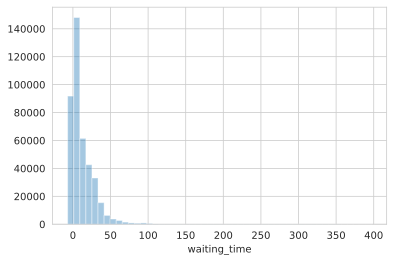

In [0]:
#Distribution for waiting_time
sns.distplot(df['waiting_time'], hist=True, kde=False)
plt.show()

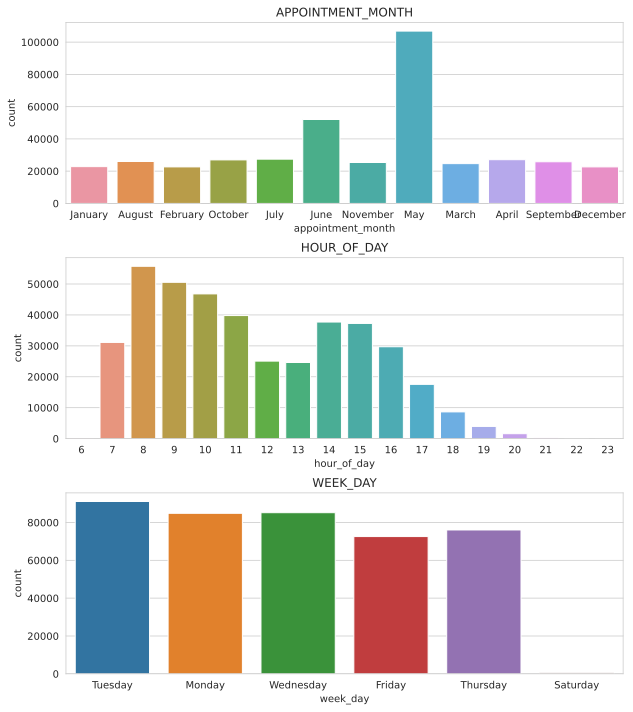

In [0]:
#plotting for other categorical variables
date_feild = ['appointment_month', 'hour_of_day', 'week_day']

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,12))
fig.subplots_adjust(hspace=0.3)

for ax, date_feild in zip(axes.flatten(), df[date_feild].columns):
    sns.countplot(x=date_feild, data=df, ax=ax)
    ax.set_title(date_feild.upper())

**Observations:**
1. **waiting_time:** it is observed that there are negative waiting_time which is incorrect also there are waiting time beyond 350 days. Need to investigate. 
2. **appointment_month:** May month seems to have the highest appoint scheduled. 
3. **hour_of_day:** most of the appointments are between 8 am to 11 am.
4. **week_day:** Tuesday has the highest appointments followed by Monday and Wednesday.

In [0]:
# removeing records waiting time < 0 and above 100 as there are only few patients 
df = df[(df.waiting_time >= 0) & (df.waiting_time <= 100)]

print('Minimum waiting time is:', df['waiting_time'].min())
print('Maximum waiting time is:', df['waiting_time'].max())

Minimum waiting time is: 0
Maximum waiting time is: 100


Calculating probability of feature with restpect to no-show

In [0]:
#Creating a fucntion to calculate probability of feature with respect to no_show
def probStatus(dataset, group_by):
    df = pd.crosstab(index = dataset[group_by], columns = dataset.no_show).reset_index()
    df['probShowUp'] = df['showup'] / (df['showup'] + df['noshow'])
    
    return df[[group_by, 'probShowUp']]

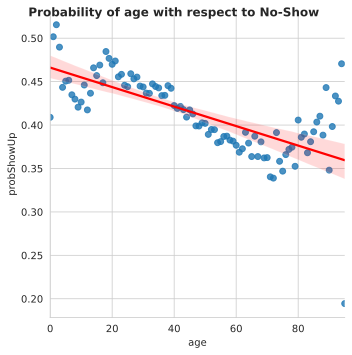

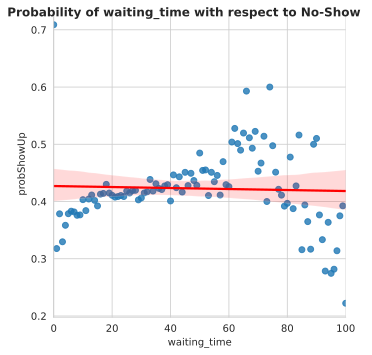

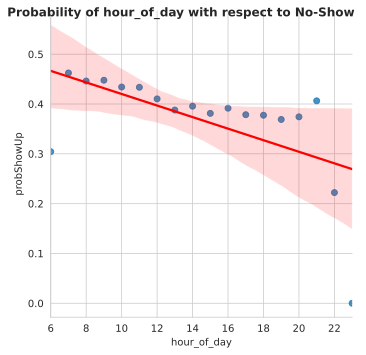

In [0]:
#checking for the below list of variables
col = ['age', 'waiting_time', 'hour_of_day']

for ax, var in zip(axes.flatten(), df[col].columns):
  lm = sns.lmplot(x = var, y = 'probShowUp', data = probStatus(df, var), fit_reg = True, line_kws={'color': 'red'})
  fig = lm.fig
  fig.suptitle(f'Probability of {var} with respect to No-Show \n\n', fontsize=12, fontweight="bold")
  ax.set_title(var.upper())

Compartively age has a better corelation with no_show variable than waiting_time and hour_of_day variables.

In [0]:
#adding a variable for encoded week_day 
df['en_week_day'] = df['week_day'].astype('category')
df["en_week_day"] = df["en_week_day"].cat.codes
df.head()

,age,gender,schedule_day,appointment_day,week_day,no_show,diabetes,alcoholism,hypertension,handicap,scholarship,sms_received,en_no_show,age_bin,waiting_time,appointment_month,en_appointment_month,hour_of_day,en_week_day
0,19,M,2014-12-16 14:46:25,2015-01-14,Tuesday,noshow,0,0,0,0,0,0,0,Young-Adult,28,January,1,15,4
1,24,F,2015-08-18 07:01:26,2015-08-19,Tuesday,noshow,0,0,0,0,0,0,0,Young-Adult,1,August,8,7,4
2,4,F,2014-02-17 12:53:46,2014-02-18,Monday,noshow,0,0,0,0,0,0,0,Children,0,February,2,13,1
3,5,M,2014-07-23 17:02:11,2014-08-07,Wednesday,noshow,0,0,0,0,0,0,0,Children,14,August,8,17,5
4,38,M,2015-10-21 15:20:09,2015-10-27,Wednesday,noshow,0,0,0,0,0,0,0,Adult,5,October,10,15,5


**Checking if any gender tend to have highest no show rate**


In [0]:
#Checking relation between gender and no_show
gender_noshow = pd.crosstab(df['gender'], df['no_show'], normalize='index')
gender_noshow

no_show,noshow,showup
gender,,
F,0.584759,0.415241
M,0.569551,0.430449


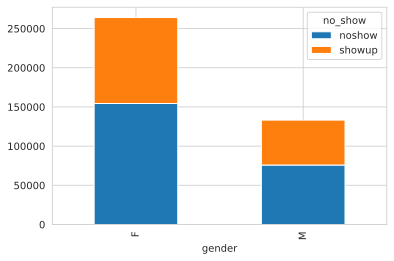

In [0]:
ct = pd.crosstab(df.gender, df['no_show'])
ct.plot.bar(stacked=True)

**Obervation:**

As seen above females have higher tendency to not show up for appointments.

**Checking if any disease tend to have highest no show rate**

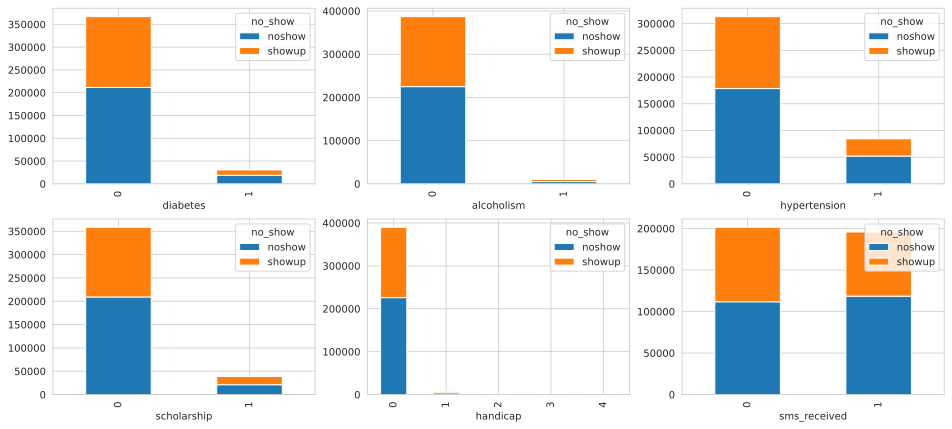

In [0]:
#Categorical features
binary_var = ['diabetes', 'alcoholism', 'hypertension', 'scholarship', 'handicap', 'sms_received' ]

fig = plt.figure(figsize=(16, 11))
for i, var in enumerate(binary_var):
    ax = fig.add_subplot(3, 3, i+1)
    df.groupby([var, 'no_show'])[var].count().unstack('no_show').plot(ax=ax, kind='bar', stacked=True)

In [0]:
#To confirm the above result checking the pvalue

chi_test_var = ['age','gender', 'diabetes', 'alcoholism', 'hypertension', 'scholarship', 'handicap', 'sms_received', 'waiting_time','en_appointment_month', 'hour_of_day', 'en_week_day']
for column in (chi_test_var):
    chi2, p, dof,ex = chi2_contingency(pd.crosstab(index=df[column], columns=df["en_no_show"]), correction=False)
    print ('chi-squared test- p value for {} is: {r:6.5f}'. format(column,r = p))

chi-squared test- p value for age is: 0.00000
chi-squared test- p value for gender is: 0.00000
chi-squared test- p value for diabetes is: 0.00000
chi-squared test- p value for alcoholism is: 0.00000
chi-squared test- p value for hypertension is: 0.00000
chi-squared test- p value for scholarship is: 0.00000
chi-squared test- p value for handicap is: 0.28620
chi-squared test- p value for sms_received is: 0.00000
chi-squared test- p value for waiting_time is: 0.00000
chi-squared test- p value for en_appointment_month is: 0.00000
chi-squared test- p value for hour_of_day is: 0.00000
chi-squared test- p value for en_week_day is: 0.00000


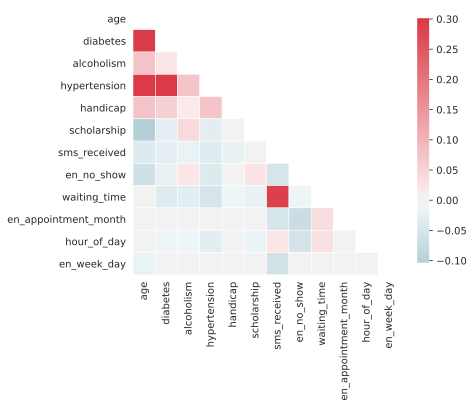

In [0]:
#Finding correlation between features
corr = df.corr()

# Generate a mask 
mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(6, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Model Implementation



In [0]:
#Encoding Categprical Variabls 

from sklearn import metrics, preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

le = preprocessing.LabelEncoder()
df['no_show'] = le.fit_transform(df['no_show'])

features = ['age', 'gender', 'hypertension', 'diabetes', 'alcoholism', 'scholarship', 'sms_received', 'waiting_time','en_appointment_month','hour_of_day','en_week_day']

for variable in features: 
  le = preprocessing.LabelEncoder()
  df[variable] = le.fit_transform(df[variable])

In [0]:
from sklearn.model_selection import train_test_split

#split data
X = df[features]
y = df['no_show']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 1)

In [0]:
print('Shape of X train data: ',X_train.shape)
print('Shape of X test data: ',X_test.shape)
print('Shape of X validation data: ',X_val.shape)
print('Shape of Y train data: ', y_train.shape)
print('Shape of Y test data: ', y_test.shape)
print('Shape of Y validation data: ',y_val.shape)

Shape of X train data:  (208551, 11)
Shape of X test data:  (119173, 11)
Shape of X validation data:  (69518, 11)
Shape of Y train data:  (208551,)
Shape of Y test data:  (119173,)
Shape of Y validation data:  (69518,)


As mentioned in "Predicting no-show if radiology using regression model of data available in the electronic medical record" (Harvey et al., 2017) article, I will be using **AUC score** to calculate the accuracy of model.

### Logistic Regression

In [0]:

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, precision_recall_curve
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

lr = LogisticRegression()

# Fit the model to the data
lr = lr.fit(X_train, y_train)

print ("Logistic Regression Model")
lr_auc = roc_auc_score(y_test, lr.predict(X_test))

print ("Logistic Regression AUC = %2.2f" % lr_auc)

lr2 = lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
print(classification_report(y_test, lr.predict(X_test)))

Logistic Regression Model
Logistic Regression AUC = 0.52
              precision    recall  f1-score   support

           0       0.59      0.91      0.72     69026
           1       0.53      0.14      0.22     50147

    accuracy                           0.59    119173
   macro avg       0.56      0.52      0.47    119173
weighted avg       0.57      0.59      0.51    119173



In [0]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

methods_data = {"Logistic Regression": (X_train, y_train)}

for method in methods_data.keys():
    #scoring=['roc_auc', 'accuracy']
    lr_results_acc = cross_val_score(LogisticRegression(), methods_data[method][0], methods_data[method][1], cv=5, scoring='accuracy')
    lr_results = cross_val_score(LogisticRegression(), methods_data[method][0], methods_data[method][1], scoring='roc_auc')
    print(f"The best AUC Score for {method} data:")
    print (lr_results.mean())
    print("Accuracy: ", lr_results_acc.mean())

The best AUC Score for Logistic Regression data:
0.5756315282564366
Accuracy:  0.5876068592243459


### Random Forest Classifier

In [0]:
#Implementing Random Forest Classifier to predict no-show

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score,accuracy_score,roc_auc_score

RFC = RandomForestClassifier(max_depth = 4, random_state = 60)
rf_parameter = {
        'n_estimators': 70, 
        'min_samples_leaf': 30
    }

# Fit the model to the data
RFC = RFC.fit(X_train, y_train)
y_pred = RFC.predict(X_test)

RFC_auc = accuracy_score(y_test, y_pred)

print ("RFC accuracy score = %2.2f" % RFC_auc)
print("RFC ROC score = %2.2f" % roc_auc_score(y_test, y_pred))


RFC accuracy score = 0.64
RFC ROC score = 0.58


### Gaussian Naive Bayes Classifier

In [0]:
from sklearn.naive_bayes import GaussianNB

GNB = GaussianNB()

# Fit the model to the data
GNB = GNB.fit(X_train, y_train)

GNB_auc = accuracy_score(y_test, GNB.predict(X_test))

print ("Naive Bayes accuracy scoure= %2.2f" % GNB_auc)
print ("Naive Bayes ROC score= %2.2f" % roc_auc_score(y_test, GNB.predict(X_test)))

Naive Bayes accuracy scoure= 0.61
Naive Bayes ROC score= 0.57


### XGBoost Classifier

In [0]:
import xgboost as xgb

param_dist = {'objective':'binary:logistic', 'n_estimators':2}

xgm = xgb.XGBModel(**param_dist)

xgm.fit(X_train, y_train)

predict_train = xgm.predict(X_train)

In [0]:
from xgboost import XGBClassifier

# Create the Original training sets
methods_data = {"Original": (X_train, y_train)}

# Loop through training sets and apply 5-Fold CV using XGBoost Classifier
# By default in cross_val_score StratifiedCV is used
for method in methods_data.keys():
    lr_results = cross_val_score(XGBClassifier(), methods_data[method][0], methods_data[method][1], cv=5, scoring='roc_auc')
    print(f"The best roc_auc Score for data:")
    print (lr_results.mean())

The best roc_auc Score for data:
0.7050757235921199


In [0]:

#checking accuracy 
for method in methods_data.keys():
    lr_results = cross_val_score(XGBClassifier(), methods_data[method][0], methods_data[method][1], cv=5, scoring='accuracy')
    print(f"The best accuracy Score for {method} data:")
    print (lr_results.mean())

The best accuracy Score for Original data:
0.6686709616393715


In [0]:
#implementing GridSearchCV and XGBoost Classifier

from sklearn.model_selection import GridSearchCV

gbm_param_grid = {
'subsample': [0.9,1],
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
  'learning_rate':[0.1,0.05],
 'n_estimators':[200,300]   
}

xgb_cl=XGBClassifier(objective= 'binary:logistic', nthread=6, tree_method='gpu_hist', eval_metric='auc',n_gpus=1,max_bin=16)

grid_mse = GridSearchCV(estimator=xgb_cl,param_grid=gbm_param_grid,scoring='roc_auc', cv=5, verbose=1,n_jobs=-1)
grid_mse.fit(X_train, y_train)
print("Best parameters found: ",grid_mse.best_params_)
print("Best ROC found: ", np.sqrt(np.abs(grid_mse.best_score_)))

In [0]:
#XGB=XGBClassifier(objective= 'binary:logistic', nthread=6, tree_method='gpu_hist', eval_metric='auc',n_gpus=1,max_bin=16,**grid_mse.best_params_)
#XGB = grid_mse.fit(X_train, y_train)

XGB_auc = roc_auc_score(y_test, grid_mse.predict(X_test))

print ("accuracy scoure= %2.2f" % XGB_auc)

### Catboost

In [0]:
pip install catboost

In [0]:
#implementing CatBoostClassfier

from catboost import CatBoostClassifier
for method in methods_data.keys():
    lr_results = cross_val_score(CatBoostClassifier(), methods_data[method][0], methods_data[method][1], cv=5, scoring='accuracy')
    print(f"The best accuracy Score for {method} data:")
    print (lr_results.mean())

Streaming output truncated to the last 5000 lines.
7:	learn: 0.6209543	total: 452ms	remaining: 56.1s
8:	learn: 0.6180782	total: 507ms	remaining: 55.9s
9:	learn: 0.6158965	total: 565ms	remaining: 55.9s
10:	learn: 0.6134722	total: 628ms	remaining: 56.4s
11:	learn: 0.6119927	total: 681ms	remaining: 56.1s
12:	learn: 0.6107017	total: 739ms	remaining: 56.1s
13:	learn: 0.6096251	total: 795ms	remaining: 56s
14:	learn: 0.6082366	total: 855ms	remaining: 56.1s
15:	learn: 0.6071493	total: 911ms	remaining: 56s
16:	learn: 0.6061820	total: 966ms	remaining: 55.8s
17:	learn: 0.6055163	total: 1.02s	remaining: 55.7s
18:	learn: 0.6047523	total: 1.09s	remaining: 56.5s
19:	learn: 0.6043297	total: 1.15s	remaining: 56.4s
20:	learn: 0.6038872	total: 1.21s	remaining: 56.4s
21:	learn: 0.6035066	total: 1.26s	remaining: 56.2s
22:	learn: 0.6031474	total: 1.33s	remaining: 56.4s
23:	learn: 0.6028725	total: 1.38s	remaining: 56.1s
24:	learn: 0.6025692	total: 1.43s	remaining: 56s
25:	learn: 0.6023593	total: 1.49s	remain

In [0]:
from sklearn.model_selection import GridSearchCV

params = {'iterations':[50], 'depth':[3], 'learning_rate':[0.1]}
    
cb_clf = CatBoostClassifier()

grid_cb = GridSearchCV(estimator=cb_clf,param_grid=params,scoring='roc_auc', cv=5, verbose=1,n_jobs=-1)
grid_cb.fit(X_train, y_train)
print("Best parameters found: ",grid_cb.best_params_)
print("Best ROC found: ", np.sqrt(np.abs(grid_cb.best_score_)))
print("Best ROC for Test found: ", roc_auc_score(y_test, grid_cb.predict(X_test)))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.1s finished


0:	learn: 0.6815934	total: 40.8ms	remaining: 2s
1:	learn: 0.6722488	total: 79ms	remaining: 1.89s
2:	learn: 0.6646508	total: 110ms	remaining: 1.72s
3:	learn: 0.6558998	total: 141ms	remaining: 1.62s
4:	learn: 0.6487196	total: 176ms	remaining: 1.59s
5:	learn: 0.6439360	total: 206ms	remaining: 1.51s
6:	learn: 0.6399492	total: 239ms	remaining: 1.47s
7:	learn: 0.6359016	total: 274ms	remaining: 1.44s
8:	learn: 0.6328055	total: 305ms	remaining: 1.39s
9:	learn: 0.6293578	total: 337ms	remaining: 1.35s
10:	learn: 0.6263270	total: 370ms	remaining: 1.31s
11:	learn: 0.6242722	total: 401ms	remaining: 1.27s
12:	learn: 0.6219249	total: 433ms	remaining: 1.23s
13:	learn: 0.6202103	total: 470ms	remaining: 1.21s
14:	learn: 0.6184367	total: 502ms	remaining: 1.17s
15:	learn: 0.6170719	total: 535ms	remaining: 1.14s
16:	learn: 0.6157610	total: 568ms	remaining: 1.1s
17:	learn: 0.6143689	total: 602ms	remaining: 1.07s
18:	learn: 0.6132979	total: 645ms	remaining: 1.05s
19:	learn: 0.6123836	total: 677ms	remaining: 

## Feature Selection 

In [0]:
data = df
print('old data shape: ',df.shape[0])
print('new data shape: ',data.shape[0])

old data shape:  397242
new data shape:  397242


In [0]:
from sklearn import metrics, preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

encode_features = ['age', 'gender', 'hypertension', 'diabetes', 'week_day','alcoholism', 'scholarship', 'sms_received', 'waiting_time','en_appointment_month','hour_of_day','en_week_day']

for variable in encode_features: 
  new_le = preprocessing.LabelEncoder()
  data[variable] = new_le.fit_transform(data[variable])

In [0]:
new_features = data.drop(['no_show', 'appointment_day', 'schedule_day', 'handicap', 'age_bin', 'appointment_month','week_day', 'en_no_show'], axis=1)
new_features.info()

new_labels = data['en_no_show']
print('\n no-show: ',new_labels.dtypes)

# Splitting dataset into train and test for features and labels
features_train, features_test, labels_train, labels_test = \
    train_test_split(new_features, new_labels, test_size=0.3, random_state=60,)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397242 entries, 0 to 410525
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   age                   397242 non-null  int64
 1   gender                397242 non-null  int64
 2   diabetes              397242 non-null  int64
 3   alcoholism            397242 non-null  int64
 4   hypertension          397242 non-null  int64
 5   scholarship           397242 non-null  int64
 6   sms_received          397242 non-null  int64
 7   waiting_time          397242 non-null  int64
 8   en_appointment_month  397242 non-null  int64
 9   hour_of_day           397242 non-null  int64
 10  en_week_day           397242 non-null  int64
dtypes: int64(11)
memory usage: 36.4 MB

 no-show:  int64


In [0]:
# Setting up CV using stratifiedshufflesplit due to imbalance of no_show.

cv = StratifiedShuffleSplit(n_splits=15, test_size=0.2, random_state=60)

In [0]:
# Fitting a tree
clf = tree.DecisionTreeClassifier(random_state=60)
clf.fit(features_train, labels_train)

# Feature Importances to see whether new feature created has any importance.
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

print ("Feature ranking: ")
for i in range(1, 10, 1):
    print ("  {}.  feature: {} ({})".format(i, features_train.columns[i], importances[indices[i]]))

Feature ranking: 
  1.  feature: gender (0.20081116276379463)
  2.  feature: diabetes (0.19901385166031663)
  3.  feature: alcoholism (0.11092428086401955)
  4.  feature: hypertension (0.0920647558148568)
  5.  feature: scholarship (0.04239899216669167)
  6.  feature: sms_received (0.02467763228642856)
  7.  feature: waiting_time (0.020220146554798892)
  8.  feature: en_appointment_month (0.02015179902886172)
  9.  feature: hour_of_day (0.013982368696113327)


**Observation:**

As per feature_importance the most important features are gender(0.2), diabetes(0.199), alcoholism(0.11), hypertension(0.09) and scholarship(0.04). 

In [0]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

selector = SelectKBest(chi2, k=2)
selector.fit_transform(features_train, labels_train)


# Storing best features and their stores in separate pd.Series
scores = pd.Series(selector.scores_)
columns = pd.Series(features_train.columns)

# Concatenating both pd.Series into one df
selectbest = pd.concat([columns, scores], axis=1)
selectbest.rename(columns={0:'features', 1:'scores'}, inplace=True)

Text(0, 0.5, 'Score')

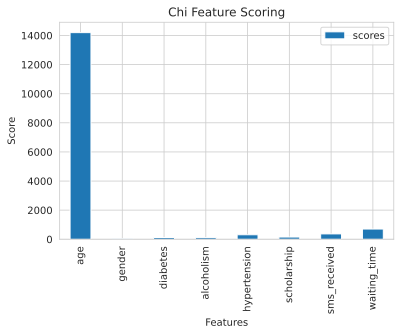

In [0]:
selectbest_plot = selectbest.iloc[:8,:].plot.bar()
selectbest_plot.set_title('Chi Feature Scoring')
selectbest_plot.set_xticklabels(selectbest['features'])
selectbest_plot.set_xlabel('Features')
selectbest_plot.set_ylabel('Score')

**Observation:**

Chi squared is chosen to score features due to the nature of the dataset. As observed above, age, waiting_time and sms_received are the top 3 feature based on Chi2 method.

As I found different features in both the test I would like to consider top 3 features Chi2 test and continue with modelling phase.

In [0]:
# Top features based on different methods
best_chi_features = ['age', 'sms_received', 'waiting_time']
best_features_importances = ['gender', 'week_day', 'diabetes',  'alcoholism','hypertension']
combined_best_features = ['age', 'sms_received','waiting_time', 'gender', 'week_day', 'diabetes',  'alcoholism','hypertension']

In [0]:
labels_test.value_counts()

0    69215
1    49958
Name: en_no_show, dtype: int64

In [0]:
print ("Patients who didn't show up: ", labels_test.mean())
print ("Patients who did show up: ", (1 - labels_test.mean()))

# Null Accuracy, ie. accuracy achieved by a dumb model if it only predicted a patient would show up to an appointment
print ("\n Null accuracy is therefore ", max(labels_test.mean(), 1 - labels_test.mean()))

Patients who didn't show up:  0.41920569256459095
Patients who did show up:  0.580794307435409

 Null accuracy is therefore  0.580794307435409


Considering only top 3 features from Chi2 method (age, waiting_time and sms_received)


In [0]:
#drop all features other than the 3 desired
new_X = data.drop(['no_show', 'en_no_show', 'gender', 'appointment_day', 'schedule_day', 'week_day', 'en_week_day', 'diabetes', 'handicap', 'scholarship', 
                   'age_bin', 'alcoholism', 'hypertension', 'appointment_month', 'hour_of_day', 'en_appointment_month'], axis=1)
new_X.info()

# dependent variable
new_y = data['en_no_show']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397242 entries, 0 to 410525
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   age           397242 non-null  int64
 1   sms_received  397242 non-null  int64
 2   waiting_time  397242 non-null  int64
dtypes: int64(3)
memory usage: 12.1 MB


In [0]:
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, new_y, test_size=0.3, random_state=60,)

Implementing Logistic Again with the new feature to check if it increases the accuracy and auc score.

In [0]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, precision_recall_curve
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

new_feature_lr = LogisticRegression()

# Fit the model to the data
new_feature_lr = new_feature_lr.fit(new_X_train, new_y_train)

print ("Logistic Regression Model")
new_feature_lr_auc = roc_auc_score(new_y_test, new_feature_lr.predict(new_X_test))

print ("Logistic Regression AUC = %2.2f" % new_feature_lr_auc)

new_feature_lr2 = new_feature_lr.fit(new_X_train, new_y_train)
new_predictions = new_feature_lr.predict(new_X_test)
print(classification_report(new_y_test, new_feature_lr.predict(new_X_test)))

Logistic Regression Model
Logistic Regression AUC = 0.50
              precision    recall  f1-score   support

           0       0.58      0.99      0.73     69215
           1       0.37      0.00      0.01     49958

    accuracy                           0.58    119173
   macro avg       0.48      0.50      0.37    119173
weighted avg       0.49      0.58      0.43    119173



In [0]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

new_methods_data = {"Logistic Regression": (new_X_train, new_y_train)}

for method in new_methods_data.keys():
    #scoring=['roc_auc', 'accuracy']
    feature_lr_results_acc = cross_val_score(LogisticRegression(), new_methods_data[method][0], new_methods_data[method][1], cv=5, scoring='accuracy')
    feature_lr_results = cross_val_score(LogisticRegression(), new_methods_data[method][0], new_methods_data[method][1], scoring='roc_auc')
    print(f"The best AUC Score for {method} data:")
    print (feature_lr_results.mean())
    print("Accuracy: ", feature_lr_results_acc.mean())

The best AUC Score for Logistic Regression data:
0.5467678258390948
Accuracy:  0.5779644644934171


As there is no change in the accuracy and auc score for logistic regression model, will implement other models.

AdaBoost Classifier with Decision Tree

In [0]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

#implementing adaboost classifier with decision tree
classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1), n_estimators = 200)
model = classifier.fit(new_X_train, new_y_train)
y_pred = model.predict(new_X_test)

In [0]:
print('Training accuracy:', metrics.accuracy_score(new_y_train, model.predict(new_X_train)))
print('Testing accuracy:',metrics.accuracy_score(new_y_test, y_pred))
print('ROC score on training dataset:',metrics.roc_auc_score(new_y_train, model.predict(new_X_train)))
print('ROC score on Testing dataset',metrics.roc_auc_score(new_y_test, y_pred))

Training accuracy: 0.6238020059769338
Testing accuracy: 0.6262072784942898
ROC score on training dataset: 0.5642086073164114
ROC score on Testing dataset 0.5652034132134115


Compared to Logistic model, Adaboost classifier has higher roc score. 

In [0]:
!pip install vecstack

In [0]:
from xgboost import XGBClassifier
from vecstack import stacking

#trying 2 different models with 4 folds each
ensem_models=[KNeighborsClassifier(), RandomForestClassifier()]

#Finding accuracy
S_train, S_test = stacking(ensem_models, new_X_train, new_y_train, new_X_test, regression = False, 
                           mode = 'oof_pred_bag', 
                           needs_proba = False, 
                           save_dir = None, 
                           metric = accuracy_score, 
                           n_folds = 4, 
                           stratified = True, 
                           shuffle = True, 
                           random_state = 0, 
                           verbose =2)

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [2]

model  0:     [KNeighborsClassifier]
    fold  0:  [0.56799678]
    fold  1:  [0.56387646]
    fold  2:  [0.56669592]
    fold  3:  [0.56614929]
    ----
    MEAN:     [0.56617961] + [0.00148947]
    FULL:     [0.56617962]

model  1:     [RandomForestClassifier]
    fold  0:  [0.60654794]
    fold  1:  [0.60621143]
    fold  2:  [0.60554972]
    fold  3:  [0.60753485]
    ----
    MEAN:     [0.60646099] + [0.00071649]
    FULL:     [0.60646099]



In [0]:
#Finding ROC score
S_train, S_test = stacking(ensem_models, new_X_train, new_y_train, new_X_test, regression = False, 
                           mode = 'oof_pred_bag', 
                           needs_proba = False, 
                           save_dir = None, 
                           metric = roc_auc_score, 
                           n_folds = 4, 
                           stratified = True, 
                           shuffle = True, 
                           random_state = 0, 
                           verbose =2)

task:         [classification]
n_classes:    [2]
metric:       [roc_auc_score]
mode:         [oof_pred_bag]
n_models:     [2]

model  0:     [KNeighborsClassifier]
    fold  0:  [0.54432583]
    fold  1:  [0.54269393]
    fold  2:  [0.54412482]
    fold  3:  [0.54437247]
    ----
    MEAN:     [0.54387926] + [0.00069065]
    FULL:     [0.54387924]

model  1:     [RandomForestClassifier]
    fold  0:  [0.56544060]
    fold  1:  [0.56493982]
    fold  2:  [0.56563042]
    fold  3:  [0.56525048]
    ----
    MEAN:     [0.56531533] + [0.00025504]
    FULL:     [0.56531535]



### **Deep** Learning

In [0]:
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras import Sequential
from tensorflow.keras import optimizers, metrics

In [0]:
# Now we build the Keras model
model = Sequential()

#layers
model.add(Dense(25, activation='relu', input_shape=(11,)))
model.add(Dense(15, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

#optimizers
rms=optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms,loss='binary_crossentropy',metrics=['accuracy'])

In [0]:
#verifing number of columns
len(features_train.columns)

11

In [0]:
# Train the model
history = model.fit(features_train,labels_train,epochs=25,batch_size=100,validation_split=0.3)

Epoch 1/25
1947/1947 [==============================] - 3s 2ms/step - loss: 0.6682 - accuracy: 0.6087 - val_loss: 0.6285 - val_accuracy: 0.6291
Epoch 2/25
1947/1947 [==============================] - 3s 2ms/step - loss: 0.6257 - accuracy: 0.6336 - val_loss: 0.6349 - val_accuracy: 0.6181
Epoch 3/25
1947/1947 [==============================] - 3s 2ms/step - loss: 0.6208 - accuracy: 0.6393 - val_loss: 0.6219 - val_accuracy: 0.6331
Epoch 4/25
1947/1947 [==============================] - 3s 2ms/step - loss: 0.6185 - accuracy: 0.6424 - val_loss: 0.6182 - val_accuracy: 0.6450
Epoch 5/25
1947/1947 [==============================] - 4s 2ms/step - loss: 0.6166 - accuracy: 0.6454 - val_loss: 0.6151 - val_accuracy: 0.6496
Epoch 6/25
1947/1947 [==============================] - 3s 2ms/step - loss: 0.6153 - accuracy: 0.6472 - val_loss: 0.6227 - val_accuracy: 0.6404
Epoch 7/25
1947/1947 [==============================] - 3s 2ms/step - loss: 0.6136 - accuracy: 0.6506 - val_loss: 0.6124 - val_accuracy:

In [0]:
loss, accuracy  = model.evaluate(features_test, labels_test, verbose=False)

In [0]:
print(f'Test loss : {loss:.5}')
print(f'Test accuracy : {accuracy:.5}')

Test loss : 0.60549
Test accuracy : 0.6673


# **Limitation & Conclusion**

**Limitation:**
*   **Limited features:** The dataset originally had only 13 features. I calculated and added features.
*   **Binary Features:** All feature in the dataset was either categorically or binary. This was the major drawback of the project and I believe it less accuracy and AUC score.
*   **Limited Data Spread:** Data Spread over limited days only which makes it difficult to generalize.

**Conclusion:**

The important features to predict if a patient is not going to show up for a medical appointment are dependent on method of feature selection. Even combination of top features from both chi2 and feature importances score does not lead to higher accuracy or auc. The best performance model is using XGBoost classifier with auc of 0.811. 

